# BigMart Sales Prediction Project

## Overview

Welcome to the BigMart Sales Prediction project! In this analysis, we aim to predict the sales of various products at BigMart outlets using the Kaggle BigMart dataset. The dataset provides information on product attributes, store details, and historical sales data.


## Objective

The main objective of this project is to build a predictive model that can accurately forecast the sales of different products at BigMart outlets. By leveraging machine learning algorithms, we seek to understand the factors that influence product sales and create a model capable of making accurate predictions.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
from scipy.stats import boxcox
from datetime import datetime

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('Train.csv')

In [6]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [7]:
df.shape

(8523, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [9]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [10]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

# Feature Engineering

In [11]:
cat_cols = [col for col, dtype in df.dtypes.items() if dtype == 'object']
print(cat_cols)

['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [12]:
columns_to_remove = ['Item_Identifier', 'Outlet_Identifier']

cat_cols = [col for col in cat_cols if col not in columns_to_remove]

print(f"2 columns deleted. Last version: {cat_cols}")

2 columns deleted. Last version: ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [13]:
df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)
df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0], inplace=True)
df['Item_Visibility'].replace(0, df['Item_Visibility'].mean(), inplace=True)
df['New_Item_Type'] = df['Item_Identifier'].str[:2]

In [14]:
item_type_mapping = {'FD': 'Food', 'NC': 'Non-Consumable', 'DR': 'Drinks'}
df['New_Item_Type'] = df['New_Item_Type'].map(item_type_mapping)

In [15]:
df.loc[df['New_Item_Type'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'

In [16]:
this_year = datetime.today().year

df['Outlet_Years'] = this_year - df['Outlet_Establishment_Year']

In [17]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,New_Item_Type,Outlet_Years
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,25
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drinks,15
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,25
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800,Food,26
4,NCD19,8.93,Non-Edible,0.066132,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Non-Consumable,37


# EDA

In [18]:
def displot(column: pd.Series, title: str):
    sns.displot(column)
    plt.title(title)
    plt.show()
    plt.savefig(f"plots/{title}.png")

In [19]:
def countplot(column: pd.Series, title: str):
    count = column.value_counts()

    chart = sns.barplot(x=count.index, y=count.values)
    chart.set_title(title)
    
    plt.savefig(f"plots/{title}.png")

    plt.show()

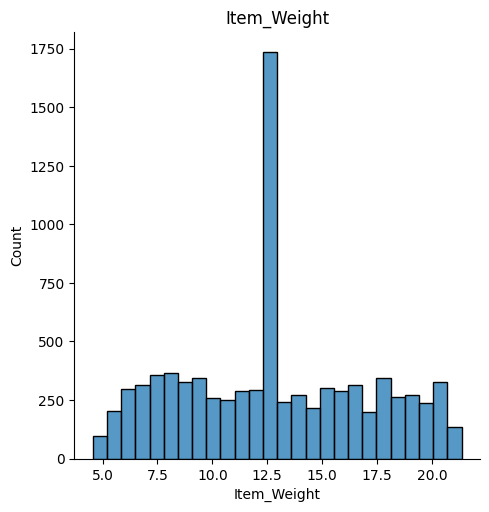

<Figure size 640x480 with 0 Axes>

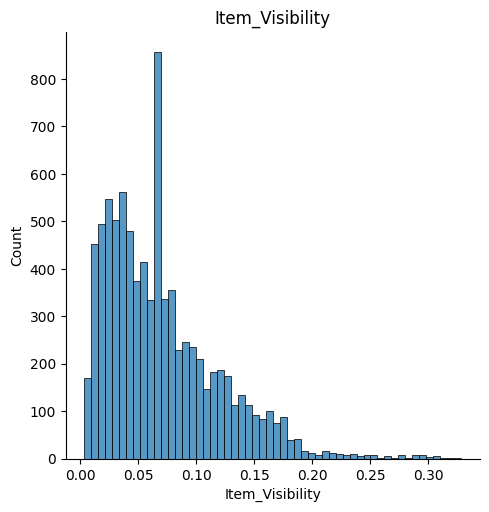

<Figure size 640x480 with 0 Axes>

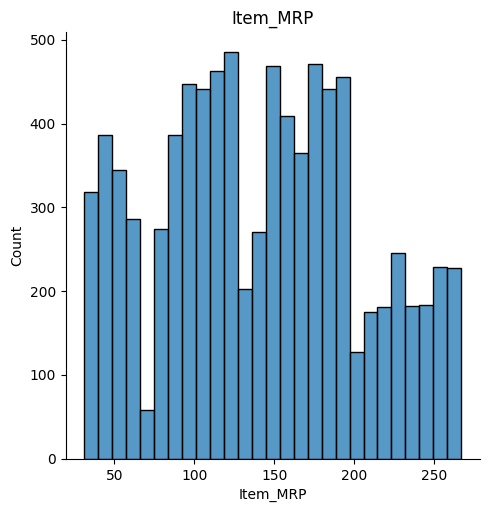

<Figure size 640x480 with 0 Axes>

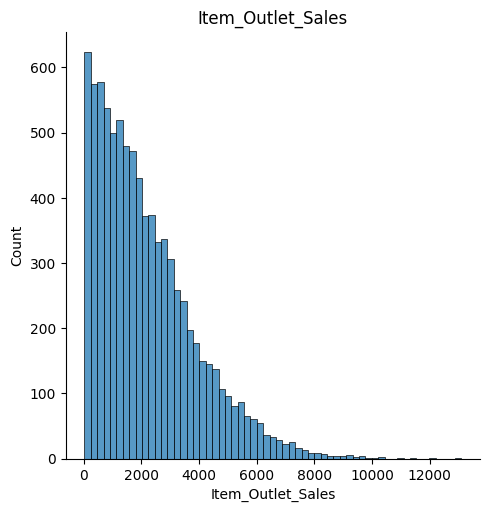

<Figure size 640x480 with 0 Axes>

In [20]:
numeric_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']

for column in numeric_columns:
    displot(df[column], column)

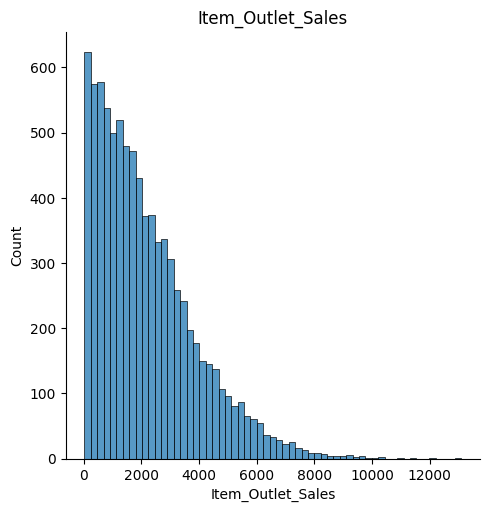

<Figure size 640x480 with 0 Axes>

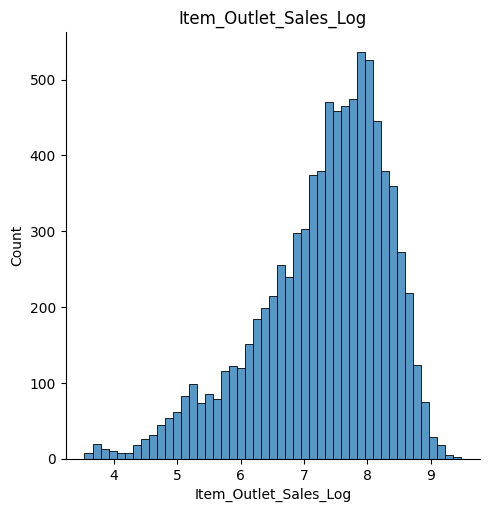

<Figure size 640x480 with 0 Axes>

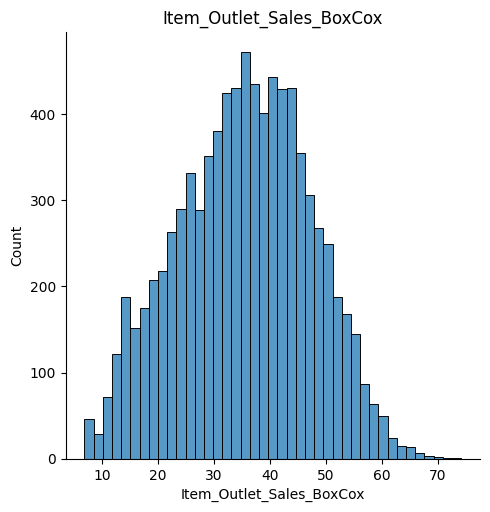

<Figure size 640x480 with 0 Axes>

In [21]:
df['Item_Outlet_Sales_Log'] = np.log(1 + df['Item_Outlet_Sales'])
df['Item_Outlet_Sales_BoxCox'], _ = boxcox(df['Item_Outlet_Sales'])


displot(df['Item_Outlet_Sales'], 'Item_Outlet_Sales')
displot(df['Item_Outlet_Sales_Log'], 'Item_Outlet_Sales_Log')
displot(df['Item_Outlet_Sales_BoxCox'], 'Item_Outlet_Sales_BoxCox')

In [22]:
df = df.drop(columns = ['Item_Outlet_Sales_Log', 'Item_Outlet_Sales'])

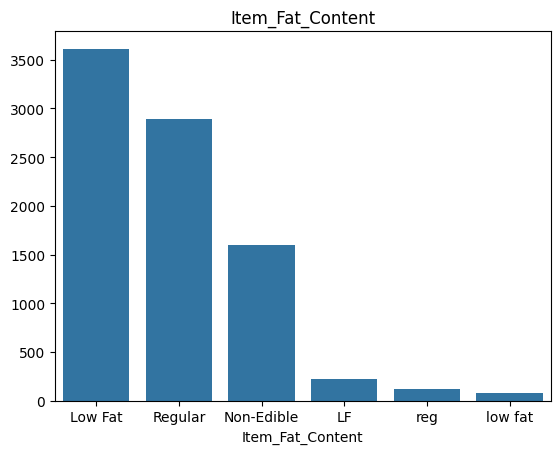

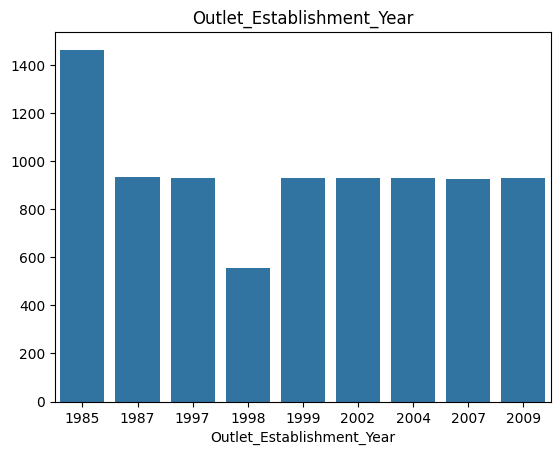

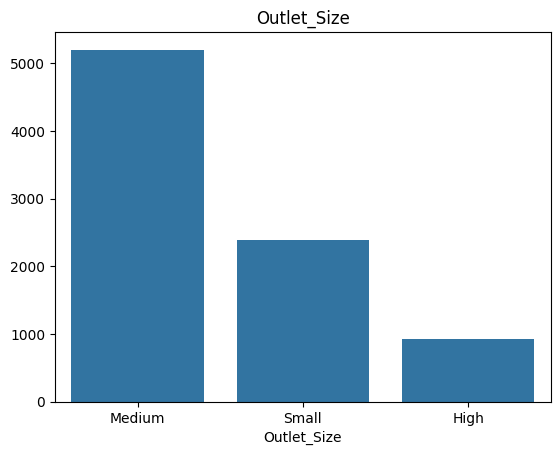

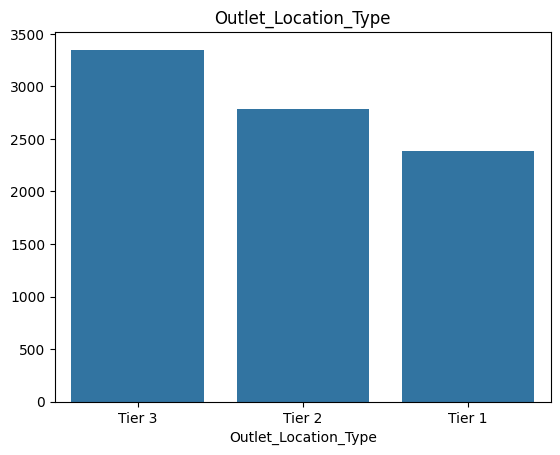

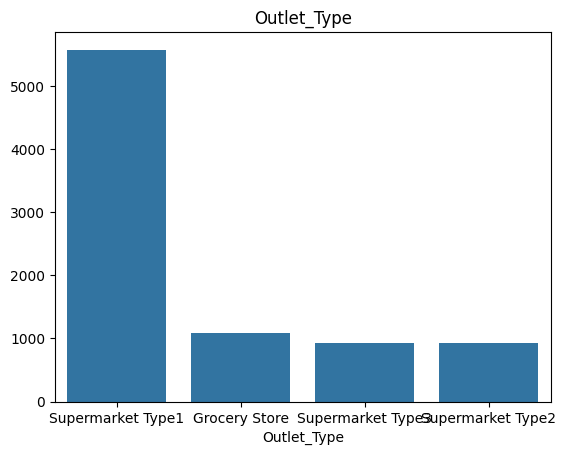

In [23]:
categorical_columns = ['Item_Fat_Content', 'Outlet_Establishment_Year', 'Outlet_Size',
                       'Outlet_Location_Type', 'Outlet_Type']

for column in categorical_columns:
    countplot(df[column], column)

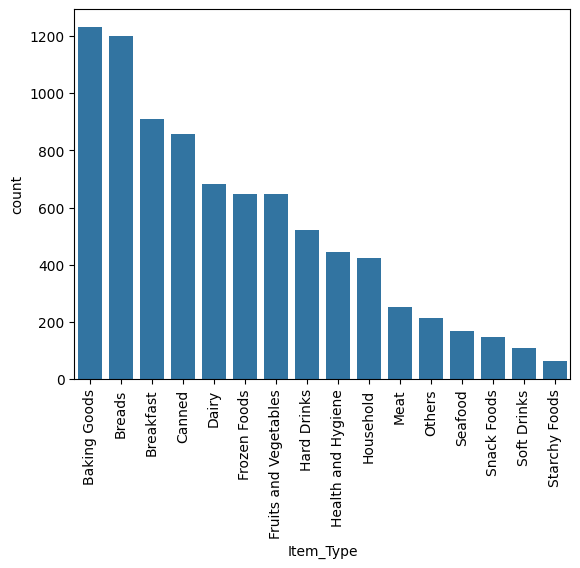

In [24]:
unique_item_types = sorted(df['Item_Type'].unique())
value_count = df['Item_Type'].value_counts()

# Plotting
c = sns.countplot(x=df['Item_Type'], order=value_count.index)
c.set_xticklabels(labels=unique_item_types, rotation=90)

# Save the plot
plt.savefig('plots/Item_Type.png')

# Display the plot
plt.show()

# Training Models

In [25]:
def train(model, train_x, train_y, test_x, test_y, ):
    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    r2 = r2_score(test_y, pred)
    cv_score = cross_val_score(model, train_x, train_y,
                               scoring='neg_mean_squared_error', cv=5)
    cv_score = np.abs(np.mean(cv_score))
    print(f"{model.__str__()} Model Report")
    print("CV Score:", cv_score)
    print("The R2 Score:", r2)
    print("")


In [26]:
def coef_plot(model_coef, X, model_name):
    features = X.columns
    coef = pd.Series(model_coef, features).sort_values(ascending=False)
    
    plot_title = "Model Coefficients - " + model_name
    coef.plot(kind='bar', title=plot_title)
    
    plt.savefig(f'plots/{plot_title}.png')
    
    plt.show()

In [27]:
X = df.drop(columns=['Outlet_Establishment_Year', 'Item_Identifier',
                     'Outlet_Identifier','Item_Outlet_Sales_BoxCox'])

In [28]:
y = df['Item_Outlet_Sales_BoxCox']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=0)

In [31]:
le = LabelEncoder()

cat_col = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'New_Item_Type']
for col in cat_col:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [34]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [33]:
lr = LinearRegression()
train(lr, X_train, y_train, X_test, y_test)

LinearRegression() Model Report
CV Score: 57.22553602592264
The R2 Score: 0.5642450151422149



In [35]:
ridge = Ridge()
train(ridge, X_train, y_train, X_test, y_test)

Ridge() Model Report
CV Score: 57.22526876107994
The R2 Score: 0.5642536169530052



In [36]:
lasso = Lasso()
train(lasso, X_train, y_train, X_test, y_test)

Lasso() Model Report
CV Score: 66.72083265613124
The R2 Score: 0.504111249120663



In [37]:
dtree = DecisionTreeRegressor()
train(dtree, X_train, y_train, X_test, y_test)

DecisionTreeRegressor() Model Report
CV Score: 85.26813273656236
The R2 Score: 0.35024273411603146



In [38]:
rand_forest = RandomForestRegressor()
train(rand_forest, X_train, y_train, X_test, y_test)

RandomForestRegressor() Model Report
CV Score: 46.09182480808984
The R2 Score: 0.6480233423764037



In [39]:
extree = ExtraTreesRegressor()
train(extree, X_train, y_train, X_test, y_test)

ExtraTreesRegressor() Model Report
CV Score: 48.509282326642364
The R2 Score: 0.6320203010506719



In [ ]:
xg = XGBRegressor()
train(xg, X_train, y_train, X_test, y_test)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) Model Report
CV Score: 51.86306416701967
The R2 Score: 0.6072105538996837



In [ ]:
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num=6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]
random_grid = {
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf}

rf = RandomForestRegressor()
rf = RandomizedSearchCV(estimator=rf,
                        param_distributions=random_grid,
                        scoring='neg_mean_squared_error',
                        n_iter=10, cv=5, verbose=2,
                        random_state=42, n_jobs=1)
rf.fit(X_train, y_train)

print(rf.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100; total time=   0.2s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5; total time=   0.4s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5; total time=   0.4s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5; total time=   0.4s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5; total time=   0.4s
[CV] END max_depth=5

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d2fb35ab-bb88-4f2f-a948-c563569cbb7d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>